In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import numpy.fft as npf
import matplotlib
import matplotlib.pyplot as plt
import time
import imagetools as im

from IPython.display import clear_output

# 4

In [2]:
x = plt.imread('assets/starfish.png')

In [3]:
y = plt.imread('assets/topgun.png')

Text(0.5, 1.0, 'Random masking')

/Users/eseetao/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


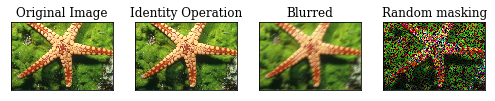

In [4]:
random_masking = im.RandomMasking(x.shape,0.4)
identity = im.Identity(x.shape)
motion_blur = im.Convolution(x.shape,im.kernel("motion"))

fig,axes = plt.subplots(nrows=1,ncols=4,figsize=(7,15))
axes[0].imshow(x)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original Image")

axes[1].imshow(identity(x))
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("Identity Operation")

axes[2].imshow(motion_blur(x))
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("Blurred")

axes[3].imshow(random_masking(x))
axes[3].set_xticks([])
axes[3].set_yticks([])
axes[3].set_title("Random masking")

# 5

In [5]:
def matrix_product(x,y):
    '''
    computes matrix dot product
    '''
    return np.sum(x*y)

## Random Masking

In [6]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(random_masking(x),y),matrix_product(x,random_masking.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Identity

In [7]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(identity(x),y),matrix_product(x,identity.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


## Convolution

In [8]:
print("Comparison of matrix products <Hx,y> and <x,H*y> returns {}".format(np.allclose(matrix_product(motion_blur(x),y),matrix_product(x,motion_blur.adjoint(y)))))

Comparison of matrix products <Hx,y> and <x,H*y> returns True


# 6

In [9]:
def inv_gram_res(obj,x,tau):
    '''
    Computes inverse of gram resolvent matrix
    Args:
        obj: operation
        x: input image
        tau: constant of regularization
    Returns:
        inverse of gram resolvent
    '''
    return x + (tau*obj.adjoint(obj(x)))

## Identity

In [10]:
confirm = identity.gram_resolvent(inv_gram_res(identity,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {0}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Random Masking

In [11]:
confirm = random_masking.gram_resolvent(inv_gram_res(random_masking,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


## Motion Blur

In [12]:
confirm = motion_blur.gram_resolvent(inv_gram_res(motion_blur,x,2),2)
print("Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is {}".format(np.allclose(confirm,x,atol=1e-2)))

Confirming that (Id + tau H*H)^-1(x + tau H*Hx) is True


# 8 

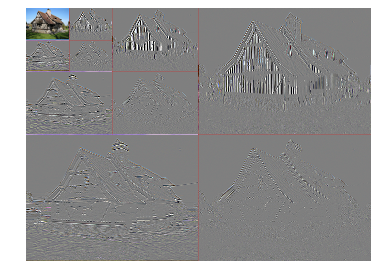

In [13]:
x0 = plt.imread("assets/normandy.png")
J = 3
h,g = im.wavelet('db2')
y0 = im.dwt(im.dwt_crop(x0,J),J,h,g)
im.showdwt(y0,J=3)

# 9

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


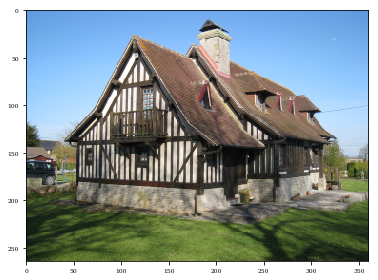

In [14]:
x = im.idwt(y0,J,h,g)
plt.imshow(x)

# 10

In [15]:
confirm = im.dwt(im.idwt(y0,J,h,g),J,h,g)
print("Confirm if dwt is left inverse idwt of {}".format(np.allclose(confirm,y0)))

Confirm if dwt is left inverse idwt of True


In [16]:
confirm = im.idwt(im.dwt(im.dwt_crop(x0,J),J,h,g),J,h,g)
print("Confirm if idwt is left inverse dwt of {}".format(np.allclose(confirm,im.dwt_crop(x0,J))))

Confirm if idwt is left inverse dwt of True


In [17]:
x=im.dwt_crop(plt.imread('assets/starfish.png'),J)
y =im.dwt_crop(plt.imread('assets/topgun.png'),J)
print("Confirm that idwt in adjoint of dwt {}".format(np.allclose(matrix_product(im.dwt(x,J,h,g),y),matrix_product(x,im.idwt(y,J,h,g)))))

Confirm that idwt in adjoint of dwt True


# 12

In [18]:
def softthresh(z,t):
    '''
    Implements soft thresholding of matrix z with threshold t
    Args:
        z: array
        t: threshold
    Returns:
        threshold: thresholded version of z
    '''
    
    threshold = np.maximum(z-t,np.zeros_like(z))+np.minimum(z+t,np.zeros_like(z))
    
    return threshold

## 13

In [19]:
def softthresh_denoise(y, sig, W, alpha=10/255):
    '''
    Removes noise by performing soft-thresholding on the wavelet coefficients
    Args:
        y: image
        sig: standard deviation
        W: wavelet transformation
    Kwargs:
        alpha: scaling factor
    Returns:
        Denoised image
    '''
    
    coeff = W(y)
    tau = np.sqrt(2)*np.square(sig)/(alpha*W.power())
    return softthresh(coeff,tau)

# 14

In [20]:
J=3
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
noisy = clean + sig * np.random.randn(*clean.shape)
#psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in [6/255, 8/255, 10/255, 12/255,16/255,20/255]]
psnr = [im.psnr(clean,W.invert(softthresh_denoise(noisy, sig, W, alpha=i/255))) for i in range(3,20)]

Text(0.5, 0, 'alpha')

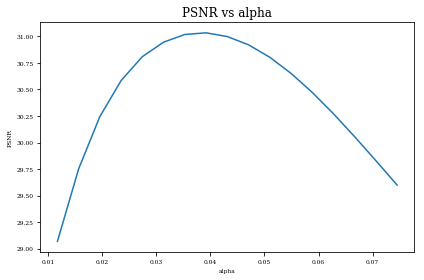

In [21]:
plt.plot([i/255 for i in range(3,20)],psnr)
plt.title("PSNR vs alpha")
plt.ylabel("PSNR")
plt.xlabel("alpha")

## 15 & 17

In [22]:

def interleave0(x):
    '''
    Upsample the filters h and g in udwt by injecting 2^(j − 1) zeros between each entries.
    Args:
        x: input vector
        j: interleaving factor
    Returns:
        x1: interleaved vector
    '''
    x1=np.zeros(((x.shape[0]-1)*2+1,1))
    x1[::2,:]=x
    return x1


def udwt(x, J, h, g):
    '''
    Implements the 2d Undecimated Discrete Wavelet Transform (UDWT) with J scales
    Args:
        x: image
        J: scales
        h: filter h
        g: filter g
    Returns:
        z: udwt transformation
    '''
    if J == 0:
        return x[:, :, None]
    tmph = np.rot90(im.convolve(np.rot90(x,k=3), h),k=1) / 2
    tmpg = np.rot90(im.convolve(np.rot90(x,k=3), g),k=1) / 2     
    z = np.stack((im.convolve(tmpg, h),im.convolve(tmph, g),im.convolve(tmph, h)), axis=2)
    coarse = im.convolve(tmpg, g)
    h2 = interleave0(h)
    g2 = interleave0(g)
    z = np.concatenate((udwt(coarse, J - 1, h2, g2), z),axis=2)
    return z

def iudwt(z, J, h, g):
    '''
    Implements the 2d Inverse UDWT
    Args:
        z: input img
        J: scales
        h: filter h
        g: filter g
    Returns:
        x: the 2D inverse UDWT
    '''
    if J == 0:
        return z[:, :, 0]
    h2 = interleave0(h)
    g2 = interleave0(g)
    coarse = iudwt(z[:, :, :-3], J - 1, h2, g2)
    tmpg = im.convolve(coarse, g[::-1]) + im.convolve(z[:, :, -3], h[::-1])
    tmph = im.convolve(z[:, :, -2], g[::-1]) + im.convolve(z[:, :, -1], h[::-1])
    x = (np.rot90(im.convolve(np.rot90(tmpg,k=3), g[::-1]),k=1) + np.rot90(im.convolve(np.rot90(tmph,k=3), h[::-1]),k=1)) / 2
    return x

In [23]:
print("Checking udwt and iudwt are inverse of each other",np.allclose(iudwt(udwt(im.dwt_crop(x0,J),J,h,g) ,J, h, g),im.dwt_crop(x0,J)))

Checking udwt and iudwt are inverse of each other True


In [24]:
source = im.dwt_crop(x0,J)
undec_wavelet = udwt(source,J,h,g)
inverse = iudwt(undec_wavelet,J,h,g)
reverse = udwt(iudwt(undec_wavelet,J,h,g),J,h,g)

## 16

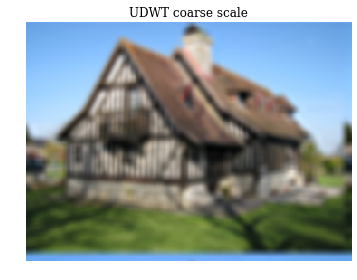

In [25]:
im.show(undec_wavelet[:,:,0,:])
plt.title("UDWT coarse scale")
plt.show()

Text(0.5, 1.0, 'Detailed Scale #6')

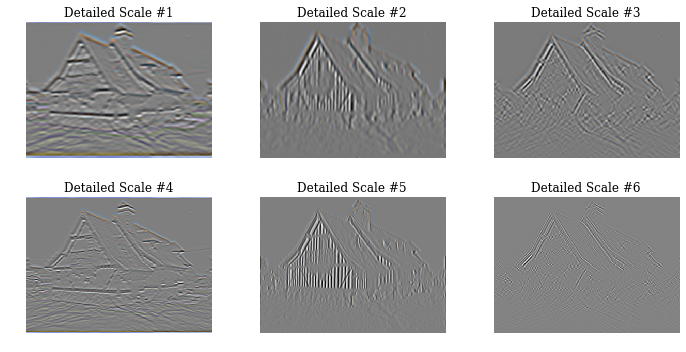

In [26]:
fig,axes= plt.subplots(nrows=2,ncols=3,figsize=(10,5))
im.show(undec_wavelet[:,:,1,:],vmin=np.min(undec_wavelet[:,:,1,:]),vmax=np.max(undec_wavelet[:,:,1,:]),ax=axes[0][0])
axes[0][0].set_title("Detailed Scale #1")
im.show(undec_wavelet[:,:,2,:],vmin=np.min(undec_wavelet[:,:,2,:]),vmax=np.max(undec_wavelet[:,:,2,:]),ax=axes[0][1])
axes[0][1].set_title("Detailed Scale #2")
im.show(undec_wavelet[:,:,3,:],vmin=np.min(undec_wavelet[:,:,3,:]),vmax=np.max(undec_wavelet[:,:,3,:]),ax=axes[0][2])
axes[0][2].set_title("Detailed Scale #3")
im.show(undec_wavelet[:,:,4,:],vmin=np.min(undec_wavelet[:,:,4,:]),vmax=np.max(undec_wavelet[:,:,4,:]),ax=axes[1][0])
axes[1][0].set_title("Detailed Scale #4")
im.show(undec_wavelet[:,:,5,:],vmin=np.min(undec_wavelet[:,:,5,:]),vmax=np.max(undec_wavelet[:,:,5,:]),ax=axes[1][1])
axes[1][1].set_title("Detailed Scale #5")
im.show(undec_wavelet[:,:,6,:],vmin=np.min(undec_wavelet[:,:,6,:]),vmax=np.max(undec_wavelet[:,:,6,:]),ax=axes[1][2])
axes[1][2].set_title("Detailed Scale #6")

## 18

In [27]:
print("Checking udwt and iudwt are left invert of each other",np.allclose(source,inverse))
print("Checking udwt and iudwt are right invert of each other",np.allclose(reverse,undec_wavelet))

Checking udwt and iudwt are left invert of each other True
Checking udwt and iudwt are right invert of each other False


UDWT and IUDWT operates in different dimensions, as such they cannot be adjoints of each other. UDWT is invertible but IUDWT is not invertible. Since the UDWT operator is not square, it is not invert

## 19

In [28]:
def udwt_create_fb(n1, n2, J, h, g, ndim=3):
    '''
    Implements UDWT with filter bank
    Args:
        n1: kernel dim n
        n2: kernel dim m
        J: scales
        h: filter h
        g: filter g
    Kwargs:
        ndim: number of dimensions
    Returns:
        fb: filter bank
    '''
    
    if J == 0:
        return np.ones((n1, n2, 1, *[1] * (ndim - 2)))
    h2 = interleave0(h,J)
    g2 = interleave0(g,J)
    fbrec = udwt_create_fb(n1, n2, J - 1, h2, g2, ndim=ndim)
    gf1 = nf.fft(fftpad(g, n1), axis=0)
    hf1 = nf.fft(fftpad(h, n1), axis=0)
    gf2 = nf.fft(fftpad(g, n2), axis=0)
    hf2 = nf.fft(fftpad(h, n2), axis=0)
    fb = np.zeros((n1, n2, 4), dtype=np.complex128)
    fb[:, :, 0] = np.outer(gf1, gf2) / 2
    fb[:, :, 1] = np.outer(gf1, hf2) / 2
    fb[:, :, 2] = np.outer(hf1, gf2) / 2
    fb[:, :, 3] = np.outer(hf1, hf2) / 2
    fb = fb.reshape(n1, n2, 4, *[1] * (ndim - 2))
    fb = np.concatenate((fb[:, :, 0:1] * fbrec, fb[:, :, -3:]),axis=2)
    return fb

In [29]:
def fb_apply(x, fb):
    '''
    Application of filter bank
    Args:
        x: image 
        fb: filter bank
    Returns:
        z: applied filter bank
    '''
    
    x = nf.fft2(x, axes=(0, 1))
    z = fb * x[:, :, np.newaxis]
    z = np.real(nf.ifft2(z, axes=(0, 1)))
    return z

In [30]:
def fb_adjoint(z, fb):
    '''
    Application of adjoint filter bank
    Args:
        z: input img
        fb: filter bank
    Returns:
        x: adjoint filter bank
    '''
    
    z = nf.fft2(z, axes=(0, 1))
    x = (np.conj(fb) * z).sum(axis=2)
    x = np.real(nf.ifft2(x, axes=(0, 1)))
    return x

## 21

In [31]:
#placeholder for softthresh_denoise 

## 22

In [32]:
def sparse_analysis_regularization(y, sig, W, H=None, m=40, alpha=10/255, gamma=1, return_energy=False):
    '''
    Computes the sparse analysis regularization via wavelet coefficients
    Args:
        y: noisy image
        sig: standard deviation
        W: (undecimated)/discrete wavelet transformation
        H: kernel linear operator
        m: iterations
        alpha: scaling factor
        gamma: must be > 0
    Kwargs:
        return_energy: if False, returns only x, if True, returns both x and e
    Returns:
        x: approximate image
        e: energy
    '''
    
    n = len(y)
    #n = len(W(x))
    if H is None:
        H = im.Identity(y.shape)

    lamb = alpha*W.power()
    #print(lamb.shape)
    
    #A = np.diag(np.diag(lamb))
    #A = lamb
    A=1
        
    #initialization
    x_til = H.adjoint(y)
    z_til = W(x_til)
    dx = 0
    dz = 0
    e = []

    tau = np.sqrt(2*np.sqrt(n/len(z_til)))*np.square(sig)
    
    for i in range(m):
        
        x = H.gram_resolvent(x_til+dx+gamma*H.adjoint(y),gamma)
        z = softthresh(z_til+dz,gamma*tau/lamb)
        
        x_til = W.gram_resolvent(x-dx+W.adjoint(z-dz),1)
        z_til = W(x_til)
        
        dx = dx - x + x_til
        dz = dz - z + z_til
        
        energy1 = 0.5*np.square(np.linalg.norm(y-H(x)))
        #energy2 = tau*np.linalg.norm(W(x),ord=1)
        #energy2 = tau*np.linalg.norm(np.linalg.inv(A)*W(x),ord=1)
        e.append(energy1)
        #energy = energy1 + energy2
        print("energy is", energy1)        
        print("finished", i+1, "iterations")
    
    if return_energy:
        return x, e
    else:
        return x

## 23

In [33]:
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.DWT(clean.shape,J)
sig = 20 / 255
ydragonfly = clean + sig * np.random.randn(*clean.shape)

DWT_SAR_dragonfly,e = sparse_analysis_regularization(ydragonfly, sig, W, return_energy=True)

energy is 0.0
finished 1 iterations
energy is 339.5736765175955
finished 2 iterations
energy is 764.0407721645884
finished 3 iterations
energy is 1039.9443843351364
finished 4 iterations
energy is 1193.8137065071687
finished 5 iterations
energy is 1274.727746614877
finished 6 iterations
energy is 1316.179611424156
finished 7 iterations
energy is 1337.1542550176516
finished 8 iterations
energy is 1347.703754611612
finished 9 iterations
energy is 1352.994048857896
finished 10 iterations
energy is 1355.643082093362
finished 11 iterations
energy is 1356.968570239177
finished 12 iterations
energy is 1357.6315571941057
finished 13 iterations
energy is 1357.9631113920736
finished 14 iterations
energy is 1358.1289036711855
finished 15 iterations
energy is 1358.2118036057707
finished 16 iterations
energy is 1358.2532545218276
finished 17 iterations
energy is 1358.2739802170386
finished 18 iterations
energy is 1358.284343123943
finished 19 iterations
energy is 1358.2895245922195
finished 20 iter

In [34]:
clean = im.dwt_crop(plt.imread("assets/dragonfly.png"),J)
W = im.UDWT(clean.shape,J)
sig = 20 / 255
ydragonfly = clean + sig * np.random.randn(*clean.shape)

UDWT_SAR_dragonfly = sparse_analysis_regularization(ydragonfly, sig, W)

energy is 0.0
finished 1 iterations
energy is 327.4314457218071
finished 2 iterations
energy is 759.8111678801511
finished 3 iterations
energy is 1055.4385496701468
finished 4 iterations
energy is 1228.907126905351
finished 5 iterations
energy is 1325.6614990674802
finished 6 iterations
energy is 1379.092811405999
finished 7 iterations
energy is 1408.9980597857307
finished 8 iterations
energy is 1426.2608755914498
finished 9 iterations
energy is 1436.7218548085818
finished 10 iterations
energy is 1443.4602318450131
finished 11 iterations
energy is 1448.1054685263102
finished 12 iterations
energy is 1451.5197823075582
finished 13 iterations
energy is 1454.1771460703924
finished 14 iterations
energy is 1456.337563942923
finished 15 iterations
energy is 1458.1547320411657
finished 16 iterations
energy is 1459.7229535986357
finished 17 iterations
energy is 1461.0988592657584
finished 18 iterations
energy is 1462.3225857206396
finished 19 iterations
energy is 1463.4244999852208
finished 20 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (6.39db)')

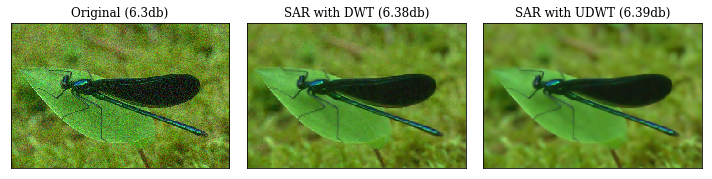

In [41]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(ydragonfly)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Original ({}db)".format(np.round(im.psnr(clean,ydragonfly),decimals=2)))

axes[1].imshow(DWT_SAR_dragonfly)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR_dragonfly),decimals=2)))

axes[2].imshow(UDWT_SAR_dragonfly)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR_dragonfly),decimals=2)))

In [46]:
np.max(clean)

1.0

In [48]:
np.min(DWT_SAR_dragonfly)

-0.13472247870795964

## 24

In [42]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.DWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
motion_blur = im.Convolution(y.shape,im.kernel("motion"))
yblurry = motion_blur(y)

H = im.Convolution(y.shape,im.kernel("motion"))
DWT_SAR = sparse_analysis_regularization(yblurry, sig, W, H=H, gamma=100)

energy is 4.692485020686908
finished 1 iterations
energy is 4.807249186485405
finished 2 iterations
energy is 4.878063142809746
finished 3 iterations
energy is 4.868255331257686
finished 4 iterations
energy is 4.945322273191431
finished 5 iterations
energy is 4.464779081524781
finished 6 iterations
energy is 4.578564451010187
finished 7 iterations
energy is 4.662965149202188
finished 8 iterations
energy is 4.743640951784342
finished 9 iterations
energy is 4.825750324120323
finished 10 iterations
energy is 4.90621057530908
finished 11 iterations
energy is 4.981786571426446
finished 12 iterations
energy is 5.050087621471645
finished 13 iterations
energy is 5.10985318564927
finished 14 iterations
energy is 5.160902791185089
finished 15 iterations
energy is 5.203851976698738
finished 16 iterations
energy is 5.2397409877567656
finished 17 iterations
energy is 5.269724142933311
finished 18 iterations
energy is 5.294886039055621
finished 19 iterations
energy is 5.316168253199895
finished 20 i

In [43]:
clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.UDWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
motion_blur = im.Convolution(y.shape,im.kernel("motion"))
yblurry = motion_blur(y)

H = im.Convolution(y.shape,im.kernel("motion"))
UDWT_SAR = sparse_analysis_regularization(yblurry, sig, W, H=H, gamma=100)

energy is 4.6877433287465
finished 1 iterations
energy is 4.794093141111212
finished 2 iterations
energy is 4.756334428538697
finished 3 iterations
energy is 4.680385156362087
finished 4 iterations
energy is 4.690435031274154
finished 5 iterations
energy is 4.739362905213762
finished 6 iterations
energy is 4.814054421480673
finished 7 iterations
energy is 4.91150595885704
finished 8 iterations
energy is 5.013853827843311
finished 9 iterations
energy is 5.104312798205282
finished 10 iterations
energy is 5.177614526559915
finished 11 iterations
energy is 5.236080739422087
finished 12 iterations
energy is 5.284060512527202
finished 13 iterations
energy is 5.324743918416328
finished 14 iterations
energy is 5.360181443321084
finished 15 iterations
energy is 5.391448240937821
finished 16 iterations
energy is 5.419082044445843
finished 17 iterations
energy is 5.443423374679626
finished 18 iterations
energy is 5.464865995372416
finished 19 iterations
energy is 5.483835027923276
finished 20 ite

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'SAR with UDWT (26.7db)')

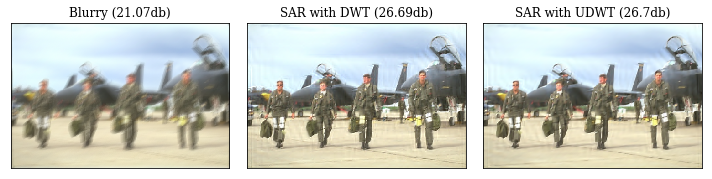

In [45]:
fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(10,25))
axes[0].imshow(motion_blur(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Blurry ({}db)".format(np.round(im.psnr(clean,yblurry),decimals=2)))

axes[1].imshow(DWT_SAR)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT ({}db)".format(np.round(im.psnr(clean,DWT_SAR),decimals=2)))

axes[2].imshow(UDWT_SAR)
axes[2].set_xticks([])
axes[2].set_yticks([])
axes[2].set_title("SAR with UDWT ({}db)".format(np.round(im.psnr(clean,UDWT_SAR),decimals=2)))

## 25

In [ ]:
#random masking 40%
#random masking 40%
#random_masking = im.RandomMasking(x.shape,0.4)

clean = im.dwt_crop(plt.imread("assets/topgun.png"),J)
W = im.DWT(clean.shape,J)
sig = 2 / 255
y = clean + sig * np.random.randn(*clean.shape)
random_masking = im.RandomMasking(x.shape,0.4)

H = im.Convolution(y.shape,im.kernel("exponential"))
DWT_SAR_masking = sparse_analysis_regularization(random_masking(y), sig, W, H=H, gamma=100)

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(7,15))
axes[0].imshow(random_masking(y))
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_title("Random Masking")

axes[1].imshow(DWT_SAR_masking)
axes[1].set_xticks([])
axes[1].set_yticks([])
axes[1].set_title("SAR with DWT")

#placeholder for UDWT